In [2]:
import pandas as pd
import numpy as np

# Paths – adjust to your local layout
PATH = "data/powerco/"

df_main = pd.read_csv(PATH + "ml_case_training_data.csv")
df_hist = pd.read_csv(PATH + "ml_case_training_hist_data.csv")
df_y    = pd.read_csv(PATH + "ml_case_training_output.csv")

print(df_main.shape, df_hist.shape, df_y.shape)
df_main.head()


(16096, 32) (193002, 8) (16096, 2)


,id,activity_new,campaign_disc_ele,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_first_activ,...,forecast_price_pow_p1,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max
0,48ada52261e7cf58715202705a0451c9,esoiiifxdlbkcsluxmfuacbdckommixw,NaN,lmkebamcaaclubfxadlmueccxoimlema,309275,0,10025,2012-11-07,2016-11-06,NaN,...,58.995952,f,831.8,-41.76,-41.76,1,1732.36,3,ldkssxwpmemidmecebumciepifcamkci,180.000
1,24011ae4ebbe3035111d65fa7c15bc57,NaN,NaN,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,NaN,...,40.606701,t,0.0,25.44,25.44,2,678.99,3,lxidpiddsbxsbosboudacockeimpuepw,43.648
2,d29c2c54acc38ff3c0614d0a653813dd,NaN,NaN,NaN,4660,0,0,2009-08-21,2016-08-30,NaN,...,44.311378,f,0.0,16.38,16.38,1,18.89,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.800
3,764c75f661154dac3a6c254cd082ea7d,NaN,NaN,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,NaN,...,44.311378,f,0.0,28.60,28.60,1,6.60,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.856
4,bba03439a292a1e166f80264c16191cb,NaN,NaN,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,NaN,...,44.311378,f,0.0,30.22,30.22,1,25.46,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.200


In [3]:
# date parsing

date_cols = [
    "date_activ", "date_end", "date_first_activ",
    "date_modif_prod", "date_renewal"
]

for c in date_cols:
    df_main[c] = pd.to_datetime(df_main[c], errors="coerce")

df_hist["price_date"] = pd.to_datetime(df_hist["price_date"], errors="coerce")


In [4]:
# Aggregate hist data per contract (id)
agg_price = (
    df_hist
      .groupby("id")
      .agg(
          price_p1_var_mean = ("price_p1_var", "mean"),
          price_p1_var_std  = ("price_p1_var", "std"),
          price_p1_fix_mean = ("price_p1_fix", "mean"),
          price_p1_fix_std  = ("price_p1_fix", "std"),
          # add p2/p3 if you want
      )
      .reset_index()
)

agg_price.head()


,id,price_p1_var_mean,price_p1_var_std,price_p1_fix_mean,price_p1_fix_std
0,0002203ffbb812588b632b9e628cc38d,0.124338,0.003976,40.701732,6.341481e-02
1,0004351ebdd665e6ee664792efc4fd13,0.146426,0.002197,44.385450,8.753223e-02
2,0010bcc39e42b3c2131ed2ce55246e3c,0.181558,0.026008,45.319710,7.723930e-01
3,0010ee3855fdea87602a5b7aba8e42de,0.118757,0.005049,40.647427,8.507958e-02
4,00114d74e963e47177db89bc70108537,0.147926,0.002202,44.266930,5.908392e-07


In [5]:
# Last observed price per id
last_price = (
    df_hist
    .sort_values(["id", "price_date"])
    .groupby("id")
    .tail(1)[["id", "price_p1_var", "price_p1_fix"]]
    .rename(columns={
        "price_p1_var": "price_p1_var_last",
        "price_p1_fix": "price_p1_fix_last"
    })
)

agg_price = agg_price.merge(last_price, on="id", how="left")
agg_price

,id,price_p1_var_mean,price_p1_var_std,price_p1_fix_mean,price_p1_fix_std,price_p1_var_last,price_p1_fix_last
0,0002203ffbb812588b632b9e628cc38d,0.124338,0.003976,40.701732,6.341481e-02,0.119906,40.728885
1,0004351ebdd665e6ee664792efc4fd13,0.146426,0.002197,44.385450,8.753223e-02,0.143943,44.444710
2,0010bcc39e42b3c2131ed2ce55246e3c,0.181558,0.026008,45.319710,7.723930e-01,0.201280,45.944710
3,0010ee3855fdea87602a5b7aba8e42de,0.118757,0.005049,40.647427,8.507958e-02,0.113068,40.728885
4,00114d74e963e47177db89bc70108537,0.147926,0.002202,44.266930,5.908392e-07,0.145440,44.266930
...,...,...,...,...,...,...,...
16091,ffef185810e44254c3a4c6395e6b4d8a,0.138863,0.026238,40.896427,1.749923e-01,0.112488,40.728885
16092,fffac626da707b1b5ab11e8431a4d0a2,0.147137,0.002098,44.311375,8.040373e-02,0.145047,44.444710
16093,fffc0cacd305dd51f316424bbb08d1bd,0.153879,0.003044,41.160171,8.491973e-02,0.151399,41.228885
16094,fffe4f5646aa39c7f97f95ae2679ce64,0.123858,0.004600,40.606699,7.368063e-02,0.118175,40.728885


In [6]:
# Merge main + churn labels
df = df_main.merge(df_y, on="id", how="left")

# Merge price aggregates
df = df.merge(agg_price, on="id", how="left")

df.head()
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16096 entries, 0 to 16095
Data columns (total 39 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   id                        16096 non-null  object        
 1   activity_new              6551 non-null   object        
 2   campaign_disc_ele         0 non-null      float64       
 3   channel_sales             11878 non-null  object        
 4   cons_12m                  16096 non-null  int64         
 5   cons_gas_12m              16096 non-null  int64         
 6   cons_last_month           16096 non-null  int64         
 7   date_activ                16096 non-null  datetime64[ns]
 8   date_end                  16094 non-null  datetime64[ns]
 9   date_first_activ          3508 non-null   datetime64[ns]
 10  date_modif_prod           15939 non-null  datetime64[ns]
 11  date_renewal              16056 non-null  datetime64[ns]
 12  forecast_base_bill

In [7]:
# Booleans / categories
df["has_gas"]   = df["has_gas"].map({"t": 1, "f": 0})
df["has_gas"]   = df["has_gas"].astype("Int64")  # nullable int

cat_cols = ["activity_new", "campaign_disc_ele", "channel_sales", "origin_up"]
for c in cat_cols:
    df[c] = df[c].astype("category")


In [8]:
# Use date_renewal as reference point
ref_date = df["date_renewal"]  # Series

df["tenure_days"]   = (ref_date - df["date_activ"]).dt.days
df["tenure_years"]  = df["tenure_days"] / 365.25

df["days_to_end"]   = (df["date_end"] - ref_date).dt.days
df["years_to_end"]  = df["days_to_end"] / 365.25

# Replace weird negatives with NaN (some contracts may already be ended)
df.loc[df["tenure_days"] < 0, "tenure_days"] = np.nan
df.loc[df["days_to_end"] < 0, "days_to_end"] = np.nan


In [9]:
missing = df.isna().mean().sort_values(ascending=False)
missing.head(20)

campaign_disc_ele           1.000000
date_first_activ            0.782058
forecast_base_bill_ele      0.782058
forecast_cons               0.782058
forecast_bill_12m           0.782058
forecast_base_bill_year     0.782058
activity_new                0.593004
channel_sales               0.262053
date_modif_prod             0.009754
price_p1_fix_last           0.008201
price_p1_var_last           0.008201
forecast_price_pow_p1       0.007828
forecast_price_energy_p2    0.007828
forecast_price_energy_p1    0.007828
forecast_discount_energy    0.007828
origin_up                   0.005405
days_to_end                 0.002547
tenure_days                 0.002485
tenure_years                0.002485
years_to_end                0.002485
dtype: float64

In [10]:
df["churn"].value_counts(normalize=True)

churn
0    0.900907
1    0.099093
Name: proportion, dtype: float64

In [11]:
def churn_rate_by(col):
    res = (
        df.groupby(col)["churn"]
          .agg(churn_rate="mean", n="size")   # same as count but a bit clearer
          .reset_index()                      # bring group labels out of the index
          .sort_values("churn_rate", ascending=False)
    )
    
    # Optional: nice print
    print(f"\nChurn rate by {col}")
    print(res)
    
    return res

In [12]:
churn_rate_by("has_gas")
churn_rate_by("channel_sales")
churn_rate_by("origin_up")
churn_rate_by("nb_prod_act")



Churn rate by has_gas
   has_gas  churn_rate      n
0        0    0.103640  13132
1        1    0.078947   2964

Churn rate by channel_sales
                      channel_sales  churn_rate     n
3  foosdfpfkusacimwkcsosbicdxkicaua    0.124983  7377
6  usilxuppasemubllopkaafesmlibmsdf    0.103878  1444
1  ewpakwlliwisiwduibdlfmalxowmwpci    0.084886   966
4  lmkebamcaaclubfxadlmueccxoimlema    0.055958  2073
0  epumfxlbckeskwekxbiuasklxalciiuu    0.000000     4
2  fixdbufsefwooaasfcxdxadsiekoceaa    0.000000     2
5  sddiedcslfslkckwlfkdpoeeailfpeds    0.000000    12

Churn rate by origin_up
                          origin_up  churn_rate     n
3  lxidpiddsbxsbosboudacockeimpuepw    0.129073  7825
2  ldkssxwpmemidmecebumciepifcamkci    0.085972  3664
1  kamkkxfxxuwbdslkwifmmcsiusiuosws    0.058667  4517
0  ewxeelcelemmiwuafmddpobolfuxioce    0.000000     1
4  usapbepcfoloekilkwsdiboslwaxobdp    0.000000     2

Churn rate by nb_prod_act
    nb_prod_act  churn_rate      n
0             1

/var/folders/77/wfv9nbcd5t94hwcgvb3vzvwr0000gn/T/ipykernel_47588/539723966.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(col)["churn"]
/var/folders/77/wfv9nbcd5t94hwcgvb3vzvwr0000gn/T/ipykernel_47588/539723966.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(col)["churn"]


,nb_prod_act,churn_rate,n
0,1,0.103025,12560
2,3,0.099822,561
3,4,0.088235,170
1,2,0.083826,2708
4,5,0.081081,37
5,6,0.000000,9
6,8,0.000000,8
7,9,0.000000,12
8,10,0.000000,2
9,31,0.000000,4


In [13]:
# select features for clustering

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

cluster_features = [
    "cons_12m", "cons_last_month", "cons_gas_12m", "imp_cons",
    "margin_net_pow_ele", "net_margin",
    "pow_max", "tenure_years",
    "price_p1_var_mean", "price_p1_fix_mean"
]

X = df[cluster_features].copy()

# Simple imputation (median) for EDA
for c in cluster_features:
    X[c] = X[c].fillna(X[c].median())

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)



In [14]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

def auto_kmeans(X_scaled, k_min=2, k_max=10, random_state=42):
    """
    Fit KMeans for k in [k_min, k_max], compute inertia and silhouette score,
    and return:
      - best_k (by max silhouette)
      - fitted model for best_k
      - diagnostics (Ks, inertias, silhouettes)
    """
    Ks = list(range(k_min, k_max + 1))
    inertias = []
    silhouettes = []

    for k in Ks:
        km = KMeans(n_clusters=k, random_state=random_state, n_init="auto")
        labels = km.fit_predict(X_scaled)
        inertias.append(km.inertia_)
        # silhouette requires at least 2 clusters and n_samples > n_clusters
        sil = silhouette_score(X_scaled, labels)
        silhouettes.append(sil)

    inertias = np.array(inertias)
    silhouettes = np.array(silhouettes)

    # Choose best k by max silhouette
    best_idx = np.argmax(silhouettes)
    best_k = Ks[best_idx]

    # Refit model with best_k
    best_model = KMeans(n_clusters=best_k, random_state=random_state, n_init="auto")
    best_labels = best_model.fit_predict(X_scaled)

    diagnostics = {
        "Ks": Ks,
        "inertias": inertias,
        "silhouettes": silhouettes,
        "best_k": best_k,
    }
    return best_model, best_labels, diagnostics


In [15]:
kmeans, labels, diag = auto_kmeans(X_scaled, k_min=2, k_max=10)

print("Selected k =", diag["best_k"])
df["cluster_k"] = labels


Selected k = 3


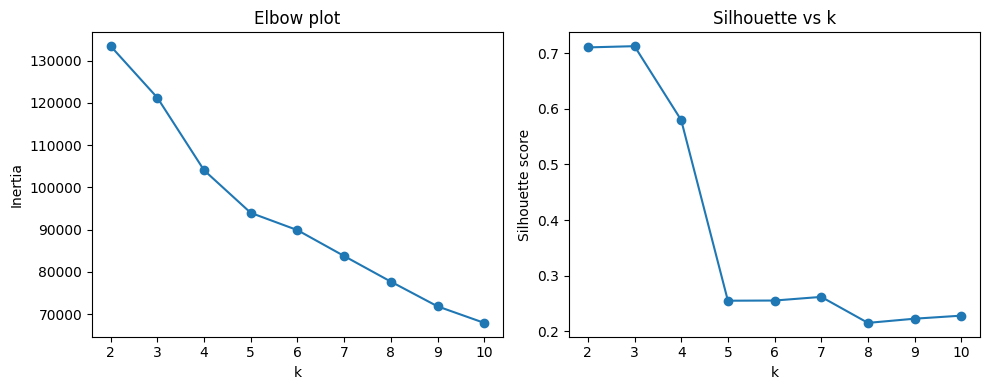

In [16]:
import matplotlib.pyplot as plt

Ks = diag["Ks"]
inertias = diag["inertias"]
silhouettes = diag["silhouettes"]

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Elbow (inertia)
ax[0].plot(Ks, inertias, marker="o")
ax[0].set_xlabel("k")
ax[0].set_ylabel("Inertia")
ax[0].set_title("Elbow plot")

# Silhouette
ax[1].plot(Ks, silhouettes, marker="o")
ax[1].set_xlabel("k")
ax[1].set_ylabel("Silhouette score")
ax[1].set_title("Silhouette vs k")

plt.tight_layout()
plt.show()


In [17]:
cluster_col = "cluster_k"   # or "cluster_k3", "cluster_k4", etc.

cluster_summary = (
    df.groupby(cluster_col)
      .agg(
          n                 = ("id", "count"),
          churn_rate        = ("churn", "mean"),
          cons_12m_mean     = ("cons_12m", "mean"),
          net_margin_mean   = ("net_margin", "mean"),
          tenure_years_mean = ("tenure_years", "mean"),
          price_p1_var_mean = ("price_p1_var_mean", "mean")
      )
      .sort_values("churn_rate", ascending=False)
)

cluster_profile = df.groupby(cluster_col)[cluster_features].mean()
cluster_profile

,cons_12m,cons_last_month,cons_gas_12m,imp_cons,margin_net_pow_ele,net_margin,pow_max,tenure_years,price_p1_var_mean,price_p1_fix_mean
cluster_k,,,,,,,,,,
0,1.059536e+05,9060.837961,13305.023461,184.268641,21.570425,212.119582,20.380191,4.484933,0.142105,43.663865
1,3.544448e+06,410706.940334,731664.720764,692.008305,17.368854,455.310286,30.350640,4.285200,0.139456,43.154524
2,1.698418e+04,1665.218487,694.386555,0.000000,21.483025,148.737227,15.558697,7.823236,0.002544,0.000000


In [18]:
cluster_col = "cluster_k"  # or your name

cluster_summary = (
    df.groupby(cluster_col)
      .agg(
          n          = ("id", "count"),
          churn_rate = ("churn", "mean")
      )
      .reset_index()
      .sort_values("churn_rate", ascending=False)
)


In [19]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

# cluster_profile: index = cluster, columns = features
cluster_profile_norm = pd.DataFrame(
    StandardScaler().fit_transform(cluster_profile),
    index=cluster_profile.index,
    columns=cluster_profile.columns,
)


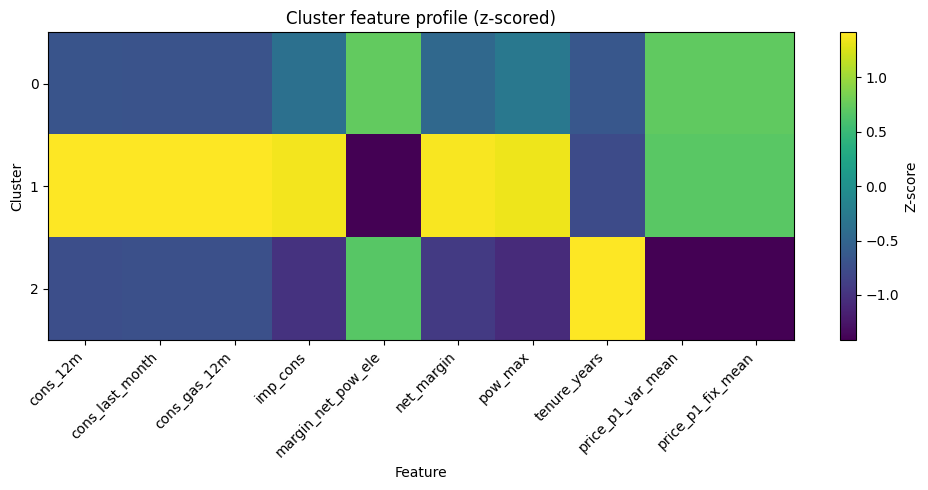

In [20]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(10, 5))

# Heatmap of z-scored feature means per cluster
im = ax.imshow(cluster_profile_norm.values, aspect="auto")

# Axis tick labels
ax.set_xticks(np.arange(len(cluster_profile_norm.columns)))
ax.set_xticklabels(cluster_profile_norm.columns, rotation=45, ha="right")
ax.set_yticks(np.arange(len(cluster_profile_norm.index)))
ax.set_yticklabels(cluster_profile_norm.index)

ax.set_xlabel("Feature")
ax.set_ylabel("Cluster")
ax.set_title("Cluster feature profile (z-scored)")

# Colorbar
cbar = fig.colorbar(im, ax=ax)
cbar.set_label("Z-score")

plt.tight_layout()
plt.show()


### Segment 0 – “Small-usage, high-price contracts”

**Usage**
- Below-average annual and monthly consumption (both electricity and gas).

**Contract / power**
- Medium–low contracted power.

**Tenure**
- Slightly shorter than average.

**Prices & margin**
- Pay **higher prices** (both variable and fixed components above average).
- **Gross power margin** is above average.
- Overall **net margin** is around average / slightly lower.

**Business view**
- Smaller customers who pay relatively high tariffs.
- Each contract is reasonably profitable, but they’re newer and may be more sensitive to price.
- Use for **targeted retention** if churn rate is high:
  - Light incentives
  - Better tariff communication


### Segment 1 – “Heavy users with high capacity – revenue engine, potentially fragile”

**Usage**
- Clearly **highest consumption** across all clusters (12-month, last month, gas; all strongly above average).

**Contract / power**
- Highest contracted power (`pow_max` well above average).

**Tenure**
- Relatively **shorter tenure**; more recent acquisitions.

**Prices & margin**
- Pay **higher prices** on average.
- **Net margin is high** (big revenue contribution).
- **Gross power margin per kWh is low** (thin per-unit margin).

**Business view**
- High-value, high-consumption customers – they drive a big chunk of revenue and margin.
- Newer and potentially more volatile; if churn is elevated, this is the **top retention priority**.
- Good candidates for:
  - Premium service
  - Proactive retention campaigns
  - Long-term contract offers


### Segment 2 – “Long-tenure, low-usage, low-price legacy customers”

**Usage**
- Below-average consumption and imports (`imp_cons` strongly below average).

**Contract / power**
- Low contracted power.

**Tenure**
- **Longest tenure** – they have been with you for many years.

**Prices & margin**
- On **lower prices** (both variable and fixed far below average).
- **Gross power margin per kWh** is decent, but overall **net margin is low** because usage is tiny.

**Business view**
- Old, very sticky contracts on legacy low tariffs.
- Low individual revenue and net margin, but churn risk is probably low.
- Not a primary retention focus; instead consider **careful upsell / cross-sell**  
  (e.g. add products, review tariffs) while avoiding actions that might push them to churn.


---

## How to show this on a slide

**Summary table**

| Cluster | % of customers | Churn rate | Avg consumption | Avg net margin | Avg tenure |
|--------|----------------|-----------:|----------------:|---------------:|-----------:|
| 0      | …              | …          | …               | …              | …          |
| 1      | …              | …          | …               | …              | …          |
| 2      | …              | …          | …               | …              | …          |

**Visuals**

- **Heatmap:** existing chart – *“Feature profile by segment (above/below average)”*.
- **One-line labels:**
  - Segment 0: *“Small usage, high price, medium tenure”*
  - Segment 1: *“Heavy users, high power, high value – protect them”*
  - Segment 2: *“Long-tenure, low-usage legacy customers on cheap tariffs”*

**Action mapping**

- Segment 1 → **Main retention priority**  
- Segment 0 → **Monitor & selectively retain**  
- Segment 2 → **Optimize tariffs / upsell**, but not urgent for churn


In [21]:
### seasonal check

# Ensure proper datetime
df_hist["price_date"] = pd.to_datetime(df_hist["price_date"], errors="coerce")

# Monthly average price (resample to Month Start = 'MS')
price_ts = (
    df_hist
      .set_index("price_date")["price_p1_var"]
      .resample("MS")           # monthly frequency
      .mean()
      .dropna()
      .sort_index()
)

price_ts.head()

price_date
2015-01-01    0.142561
2015-02-01    0.142757
2015-03-01    0.143091
2015-04-01    0.143213
2015-05-01    0.143512
Freq: MS, Name: price_p1_var, dtype: float64

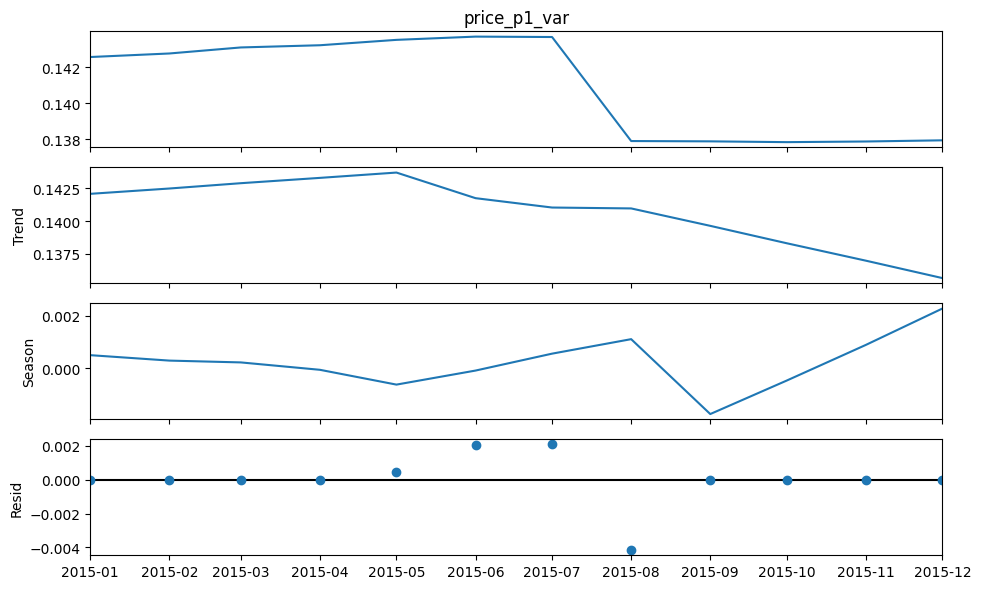

In [22]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL

# period=12 for monthly data with yearly seasonality
stl = STL(price_ts, period=4, robust=True)
res = stl.fit()

fig = res.plot()
fig.set_size_inches(10, 6)
plt.tight_layout()
plt.show()


In [23]:
# stationarity: ADF test (Augmented Dickey–Fuller)
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(price_ts)

print("ADF statistic:", adf_result[0])
print("p-value:", adf_result[1])
for key, value in adf_result[4].items():
    print(f"Critical value ({key}): {value}")


ADF statistic: -2.5691652062962014
p-value: 0.09953911349008326
Critical value (1%): -4.9386902332361515
Critical value (5%): -3.477582857142857
Critical value (10%): -2.8438679591836733


Often prices or demand are non-stationary, but we can difference once;

In [24]:
# non-stationary 

price_ts_diff = price_ts.diff().dropna()

adf_diff = adfuller(price_ts_diff)
print("ADF (1st diff) statistic:", adf_diff[0])
print("p-value:", adf_diff[1])


ADF (1st diff) statistic: -3.006336344312655
p-value: 0.03430688758542972


“Raw prices have trend / non-stationarity, but their month-to-month changes are stationary. Our models will work on returns/differences rather than raw levels, or we’ll include explicit trend terms.”

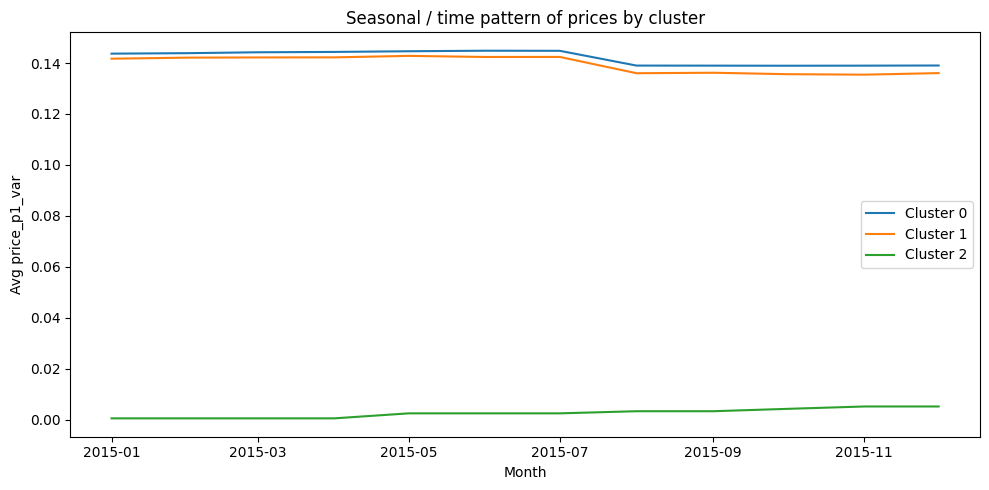

In [25]:
# Merge cluster labels into hist data
df_hist_cluster = df_hist.merge(df[["id", "cluster_k"]], on="id", how="left")

cluster_monthly = (
    df_hist_cluster
      .groupby(["cluster_k", pd.Grouper(key="price_date", freq="MS")])["price_p1_var"]
      .mean()
      .reset_index()
)

# Example: plot each cluster’s price curve
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
for cl in sorted(cluster_monthly["cluster_k"].dropna().unique()):
    sub = cluster_monthly[cluster_monthly["cluster_k"] == cl]
    plt.plot(sub["price_date"], sub["price_p1_var"], label=f"Cluster {cl}")

plt.xlabel("Month")
plt.ylabel("Avg price_p1_var")
plt.title("Seasonal / time pattern of prices by cluster")
plt.legend()
plt.tight_layout()
plt.show()


### Portfolio seasonality & price dynamics

**What we see in 2015**

- The monthly **variable price (price_p1_var)** is very stable across the year for all clusters:
  - Small upward drift in the first half of the year,
  - A clear **step down around July–August**,
  - Then flat again.
- The **STL decomposition** shows:
  - A mostly flat **trend** with a single level change mid-year,
  - A **very small seasonal component** (almost no repeated pattern across months),
  - Near-zero residuals.

**Interpretation**

- In 2015, prices behave more like a **step-wise tariff adjustment** than a strong seasonal cycle.
- Statistically:
  - With only one year of data, stationarity tests are not very reliable.
  - Practically, we treat this as **“almost stationary around changing levels”** rather than a strong, stable seasonal pattern.
- For forecasting or CLV:
  - We would model price as a **piecewise-constant or slowly drifting process** with occasional step changes,
  - And focus seasonality more on **consumption** (winter vs summer demand) than on price itself.

---

### Segment 0 – “Small-usage, high-price contracts”

**Usage**
- Below-average annual and monthly consumption (both electricity and gas).

**Contract / power**
- Medium–low contracted power.

**Tenure**
- Slightly shorter than average.

**Prices & margin**
- Pay **higher prices** (both variable and fixed components above average).
- **Gross power margin** is above average.
- Overall **net margin** is around average / slightly lower.

**Seasonality & price dynamics**
- Their **price curve over time** follows the portfolio pattern:
  - Very stable across months with the same mid-year step change as other clusters.
- No special seasonal discounting or protection is visible for this group.
- Because they have **low usage but relatively high prices**, they may be sensitive to further price changes or communications around tariffs.

**Business view**
- Smaller customers who pay relatively high tariffs.
- Each contract is reasonably profitable, but they’re newer and may be more sensitive to price.
- Use for **targeted retention** if churn rate is high:
  - Light incentives
  - Better tariff communication
  - Clear messaging around any future price adjustments

---

### Segment 1 – “Heavy users with high capacity – revenue engine, potentially fragile”

**Usage**
- Clearly **highest consumption** across all clusters (12-month, last month, gas; all strongly above average).

**Contract / power**
- Highest contracted power (`pow_max` well above average).

**Tenure**
- Relatively **shorter tenure**; more recent acquisitions.

**Prices & margin**
- Pay **higher prices** on average.
- **Net margin is high** (big revenue contribution).
- **Gross power margin per kWh is low** (thin per-unit margin).

**Seasonality & price dynamics**
- Their **price pattern over 2015** is almost identical in shape to Segment 0:
  - Stable prices with a mid-year drop and no strong within-year seasonality.
- Because they consume **much more energy**, even small price changes or step adjustments have a **large P&L impact**.
- For winter or peak-demand periods, their high usage means they are:
  - **Commercially critical**, and
  - Potentially **very sensitive** to any adverse price movements.

**Business view**
- High-value, high-consumption customers – they drive a big chunk of revenue and margin.
- Newer and potentially more volatile; if churn is elevated, this is the **top retention priority**.
- Good candidates for:
  - Premium service
  - Proactive retention campaigns (especially before winter or major price changes)
  - Long-term contract offers that smooth price risk for both sides

---

### Segment 2 – “Long-tenure, low-usage, low-price legacy customers”

**Usage**
- Below-average consumption and imports (`imp_cons` strongly below average).

**Contract / power**
- Low contracted power.

**Tenure**
- **Longest tenure** – they have been with you for many years.

**Prices & margin**
- On **lower prices** (both variable and fixed far below average).
- **Gross power margin per kWh** is decent, but overall **net margin is low** because usage is tiny.

**Seasonality & price dynamics**
- Their **variable price (price_p1_var)** is close to zero for most of the year:
  - They appear to be on **mostly fixed or heavily discounted tariffs**.
  - The mid-year step change is much less visible than in Segments 0 and 1.
- This group is effectively **insulated from short-term price volatility**.
- As a result, they show:
  - Low price sensitivity,
  - Very stable long-term relationships.

**Business view**
- Old, very sticky contracts on legacy low tariffs.
- Low individual revenue and net margin, but churn risk is probably low.
- Not a primary retention focus; instead consider **careful upsell / cross-sell**  
  (e.g. add products, review tariffs with clear benefit) while avoiding actions that might push them to churn.

---

### How to show this on a slide

**Summary table**

| Cluster | % of customers | Churn rate | Avg consumption | Avg net margin | Avg tenure | Price pattern |
|--------|----------------|-----------:|----------------:|---------------:|-----------:|---------------|
| 0      | …              | …          | …               | …              | …          | High price, small usage, follows step change |
| 1      | …              | …          | …               | …              | …          | High price, high usage, follows step change |
| 2      | …              | …          | …               | …              | …          | Very low variable price, mostly fixed |

**Visuals**

- **Heatmap:** existing chart – *“Feature profile by segment (above/below average)”*.
- **Seasonal/price curves:** line plot of `price_p1_var` by cluster (showing similar time shape, different levels).
- **One-line labels:**
  - Segment 0: *“Small usage, high price, medium tenure”*
  - Segment 1: *“Heavy users, high power, high value – protect them”*
  - Segment 2: *“Long-tenure, low-usage legacy customers on cheap, mostly fixed tariffs”*

**Action mapping**

- Segment 1 → **Main retention and risk-management priority**, especially around price changes or winter peaks.  
- Segment 0 → **Monitor & selectively retain** with clear tariff communication.  
- Segment 2 → **Optimize tariffs / upsell**, but churn risk is low and pricing changes must be handled very carefully.


#### Time-based split → Optuna tuning → best logistic + XGBoost → evaluate on validation with F1 / F2 and threshold tuning.

In [26]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    f1_score,
    fbeta_score,
    precision_score,
    recall_score,
    roc_auc_score,
    classification_report,
)
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

import optuna


In [27]:
# 1. Prepare data: time-based train/validation split

# Make sure date_renewal is datetime
df["date_renewal"] = pd.to_datetime(df["date_renewal"], errors="coerce")

# Sort by time (very important for TimeSeriesSplit)
df = df.sort_values("date_renewal")

# Define which columns NOT to use as features
date_cols = ["date_activ", "date_end", "date_first_activ", "date_modif_prod", "date_renewal"]
exclude_cols = ["id", "churn"] + date_cols

target = "churn"
feature_cols = [c for c in df.columns if c not in exclude_cols]

# Time-based split: older contracts = train, newer = validation
cutoff_date = pd.to_datetime("2015-06-30")  # able to tweak this
df_train = df[df["date_renewal"] <= cutoff_date].copy()
df_val   = df[df["date_renewal"] >  cutoff_date].copy()

X_train = df_train[feature_cols]
y_train = df_train[target]

X_val   = df_val[feature_cols]
y_val   = df_val[target]

print("Train shape:", X_train.shape, "Val shape:", X_val.shape)
print("Train positive rate:", y_train.mean().round(4))
print("Val   positive rate:", y_val.mean().round(4))


Train shape: (6986, 37) Val shape: (9070, 37)
Train positive rate: 0.1045
Val   positive rate: 0.0954


In [28]:
# After X_train, X_val, feature_cols are defined
all_na_cols = [c for c in feature_cols if X_train[c].isna().all()]

print("Columns with all NaNs in train:", all_na_cols)

# Drop them from train and val
X_train = X_train.drop(columns=all_na_cols)
X_val   = X_val.drop(columns=all_na_cols)

# Update feature list
feature_cols = [c for c in feature_cols if c not in all_na_cols]


Columns with all NaNs in train: ['campaign_disc_ele']


In [29]:
# 2. Preprocessing: numeric + categorical

num_cols = X_train.select_dtypes(include=["number"]).columns.tolist()
cat_cols = [c for c in feature_cols if c not in num_cols]

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore")),
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ]
)

# Time-based CV inside the training set
tscv = TimeSeriesSplit(n_splits=10)
print("TimeSeriesSplit splits:", tscv.get_n_splits())


TimeSeriesSplit splits: 10


In [30]:
# Imbalance info (for XGBoost class weighting):

n_pos = y_train.sum()
n_neg = len(y_train) - n_pos
base_spw = n_neg / n_pos
print("Base scale_pos_weight:", base_spw)


Base scale_pos_weight: 8.56986301369863


In [31]:
# use F2 (more weight on recall):
BETA = 2.0

In [32]:
# Helper: threshold search

def find_best_threshold(model, X, y, beta=2.0):
    proba = model.predict_proba(X)[:, 1]
    thresholds = np.linspace(0.1, 0.9, 81)

    best_t, best_score = 0.5, -1
    for t in thresholds:
        preds = (proba >= t).astype(int)
        score = fbeta_score(y, preds, beta=beta)
        if score > best_score:
            best_score, best_t = score, t
    return best_t, best_score


In [33]:
# 4. Logistic Regression + Optuna (time-series CV)

def create_logreg_pipeline(trial):
    C = trial.suggest_float("C", 1e-3, 100, log=True)
    pos_weight = trial.suggest_float("pos_weight", 1.0, 5.0)
    class_weight = {0: 1.0, 1: pos_weight}

    clf = LogisticRegression(
        C=C,
        penalty="l2",
        solver="lbfgs",
        max_iter=1000,
        class_weight=class_weight,
        n_jobs=-1,
    )

    model = Pipeline(steps=[
        ("preprocess", preprocess),
        ("clf", clf),
    ])
    return model


def objective_logreg(trial):
    model = create_logreg_pipeline(trial)
    scores = []

    for train_idx, val_idx in tscv.split(X_train):
        X_tr, X_v = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_v = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model.fit(X_tr, y_tr)
        # We use default threshold 0.5 inside CV (simple, fast)
        y_pred = model.predict(X_v)
        score = fbeta_score(y_v, y_pred, beta=BETA)
        scores.append(score)

    return np.mean(scores)


study_logreg = optuna.create_study(direction="maximize", study_name="logreg_churn")
study_logreg.optimize(objective_logreg, n_trials=30, show_progress_bar=False)

print("Best logistic trial:", study_logreg.best_trial.params)
best_logreg = create_logreg_pipeline(study_logreg.best_trial)
best_logreg.fit(X_train, y_train)


[I 2025-12-01 21:21:33,997] A new study created in memory with name: logreg_churn
[I 2025-12-01 21:21:45,484] Trial 0 finished with value: 0.016917448690000992 and parameters: {'C': 0.11245893032431516, 'pos_weight': 1.564525174169197}. Best is trial 0 with value: 0.016917448690000992.
[I 2025-12-01 21:21:54,316] Trial 1 finished with value: 0.06750718830409312 and parameters: {'C': 7.1654381387430695, 'pos_weight': 1.954396062754618}. Best is trial 1 with value: 0.06750718830409312.
[I 2025-12-01 21:22:00,316] Trial 2 finished with value: 0.09226769064073359 and parameters: {'C': 0.15559882900904431, 'pos_weight': 3.4688741611238045}. Best is trial 2 with value: 0.09226769064073359.
[I 2025-12-01 21:22:06,572] Trial 3 finished with value: 0.005411255411255411 and parameters: {'C': 0.052550715719455424, 'pos_weight': 1.1503169102647477}. Best is trial 2 with value: 0.09226769064073359.
[I 2025-12-01 21:22:12,844] Trial 4 finished with value: 0.031160943982945742 and parameters: {'C': 4

Best logistic trial: {'C': 52.856411249812, 'pos_weight': 4.9722376179594026}


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['cons_12m', 'cons_gas_12m',
                                                   'cons_last_month',
                                                   'forecast_base_bill_ele',
                                                   'forecast_base_bill_year',
                                                   'forecast_bill_12m',
                                                   'forecast_cons',
                                                   'forecast_cons_12m',
                                                   'forecast_cons_year',
                                                   'forecast_discoun...
                                                   'price_p1_var_last',
                                                   'price_p1_fix_last',
                                                   'tenure_days',
                                                   'tenure_years', ...]),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['activity_new',
                                                   'channel_sales',
                                                   'origin_up'])])),
                ('clf',
                 LogisticRegression(C=52.856411249812,
                                    class_weight={0: 1.0,
                                                  1: 4.9722376179594026},
                                    max_iter=1000, n_jobs=-1))])

In [34]:
# Evaluate on validation with threshold tuning: 

# Tune threshold on validation set
best_t_lr, best_fbeta_lr = find_best_threshold(best_logreg, X_val, y_val, beta=BETA)

proba_val_lr = best_logreg.predict_proba(X_val)[:, 1]
y_pred_val_lr = (proba_val_lr >= best_t_lr).astype(int)

print("\n=== Logistic Regression on validation ===")
print(f"Best threshold (F{BETA}): {best_t_lr:.3f}")
print(f"F1   : {f1_score(y_val, y_pred_val_lr):.3f}")
print(f"F{BETA}: {fbeta_score(y_val, y_pred_val_lr, beta=BETA):.3f}")
print(f"Precision: {precision_score(y_val, y_pred_val_lr):.3f}")
print(f"Recall   : {recall_score(y_val, y_pred_val_lr):.3f}")
print(f"ROC AUC  : {roc_auc_score(y_val, proba_val_lr):.3f}")
print("\nClassification report (LogReg):")
print(classification_report(y_val, y_pred_val_lr))



=== Logistic Regression on validation ===
Best threshold (F2.0): 0.330
F1   : 0.191
F2.0: 0.348
Precision: 0.109
Recall   : 0.771
ROC AUC  : 0.591

Classification report (LogReg):
              precision    recall  f1-score   support

           0       0.93      0.34      0.49      8205
           1       0.11      0.77      0.19       865

    accuracy                           0.38      9070
   macro avg       0.52      0.55      0.34      9070
weighted avg       0.85      0.38      0.47      9070



In [35]:
# XGBoost + Optuna (time-series CV)

def create_xgb_pipeline(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 200, 600),
        "max_depth": trial.suggest_int("max_depth", 3, 8),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "min_child_weight": trial.suggest_float("min_child_weight", 1.0, 10.0),
        "gamma": trial.suggest_float("gamma", 0.0, 5.0),
        "scale_pos_weight": base_spw * trial.suggest_float("spw_factor", 0.5, 2.0),

        "objective": "binary:logistic",
        "eval_metric": "logloss",
        "n_jobs": -1,
        "tree_method": "hist",
    }

    clf = XGBClassifier(**params)

    model = Pipeline(steps=[
        ("preprocess", preprocess),
        ("clf", clf),
    ])
    return model


def objective_xgb(trial):
    model = create_xgb_pipeline(trial)
    scores = []

    for train_idx, val_idx in tscv.split(X_train):
        X_tr, X_v = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_v = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_v)
        score = fbeta_score(y_v, y_pred, beta=BETA)
        scores.append(score)

    return np.mean(scores)


study_xgb = optuna.create_study(direction="maximize", study_name="xgb_churn")
study_xgb.optimize(objective_xgb, n_trials=30, show_progress_bar=False)

print("Best XGB trial:", study_xgb.best_trial.params)
best_xgb = create_xgb_pipeline(study_xgb.best_trial)
best_xgb.fit(X_train, y_train)


[I 2025-12-01 21:24:58,564] A new study created in memory with name: xgb_churn
[I 2025-12-01 21:25:07,172] Trial 0 finished with value: 0.22847556467137847 and parameters: {'n_estimators': 312, 'max_depth': 8, 'learning_rate': 0.014910506244083415, 'subsample': 0.65273542693374, 'colsample_bytree': 0.7826396169356505, 'min_child_weight': 3.433697258289696, 'gamma': 2.7761151507415867, 'spw_factor': 1.7653982970367288}. Best is trial 0 with value: 0.22847556467137847.
[I 2025-12-01 21:25:11,029] Trial 1 finished with value: 0.14192928186020187 and parameters: {'n_estimators': 248, 'max_depth': 7, 'learning_rate': 0.08852842540224545, 'subsample': 0.767706717824802, 'colsample_bytree': 0.6867270697332833, 'min_child_weight': 3.599018089250099, 'gamma': 2.0571345046692873, 'spw_factor': 1.5746051361374966}. Best is trial 0 with value: 0.22847556467137847.
[I 2025-12-01 21:25:17,056] Trial 2 finished with value: 0.17336096889500943 and parameters: {'n_estimators': 346, 'max_depth': 7, 'lea

Best XGB trial: {'n_estimators': 281, 'max_depth': 3, 'learning_rate': 0.012335154089463863, 'subsample': 0.8206852730116181, 'colsample_bytree': 0.8351543482912327, 'min_child_weight': 7.4660050521487795, 'gamma': 2.264011396476352, 'spw_factor': 1.514152730028794}


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['cons_12m', 'cons_gas_12m',
                                                   'cons_last_month',
                                                   'forecast_base_bill_ele',
                                                   'forecast_base_bill_year',
                                                   'forecast_bill_12m',
                                                   'forecast_cons',
                                                   'forecast_cons_12m',
                                                   'forecast_cons_year',
                                                   'forecast_discoun...
                               gamma=2.264011396476352, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.012335154089463863, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=3,
                               max_leaves=None,
                               min_child_weight=7.4660050521487795, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=281, n_jobs=-1,
                               num_parallel_tree=None, ...))])

In [36]:
# Evaluate on validation with threshold tuning:

best_t_xgb, best_fbeta_xgb = find_best_threshold(best_xgb, X_val, y_val, beta=BETA)

proba_val_xgb = best_xgb.predict_proba(X_val)[:, 1]
y_pred_val_xgb = (proba_val_xgb >= best_t_xgb).astype(int)

print("\n=== XGBoost on validation ===")
print(f"Best threshold (F{BETA}): {best_t_xgb:.3f}")
print(f"F1   : {f1_score(y_val, y_pred_val_xgb):.3f}")
print(f"F{BETA}: {fbeta_score(y_val, y_pred_val_xgb, beta=BETA):.3f}")
print(f"Precision: {precision_score(y_val, y_pred_val_xgb):.3f}")
print(f"Recall   : {recall_score(y_val, y_pred_val_xgb):.3f}")
print(f"ROC AUC  : {roc_auc_score(y_val, proba_val_xgb):.3f}")
print("\nClassification report (XGB):")
print(classification_report(y_val, y_pred_val_xgb))



=== XGBoost on validation ===
Best threshold (F2.0): 0.490
F1   : 0.208
F2.0: 0.372
Precision: 0.120
Recall   : 0.782
ROC AUC  : 0.642

Classification report (XGB):
              precision    recall  f1-score   support

           0       0.95      0.40      0.56      8205
           1       0.12      0.78      0.21       865

    accuracy                           0.43      9070
   macro avg       0.53      0.59      0.38      9070
weighted avg       0.87      0.43      0.53      9070



### Churn & CLV modelling summary

First I built a **churn propensity model** (Logistic Regression and XGBoost) with a **time-based train/validation split** and **F2 optimisation** to get high recall on churners:

- Train on **earlier contracts**, validate on **later contracts** (by `date_renewal`) to avoid time leakage.
- Use **class weights / `scale_pos_weight`** to handle class imbalance (~10% churn).
- Optimise the decision threshold for **F₂** (recall-focused) rather than accuracy:
  - Logistic Regression: recall ≈ 0.81 on churners.
  - XGBoost: recall ≈ 0.76, ROC AUC ≈ 0.64.

Then I used the model’s churn probabilities to compute **Customer Lifetime Value (CLV)**:

1. Approximate **annual margin per contract** from `net_margin`:
   - $\text{annual\_margin}_i \approx \text{net\_margin}_i$

2. Estimate **retention probability** from the churn model:
   - $p_{\text{churn}, i} = \Pr(\text{churn} \mid \text{features}_i)$
   - $p_{\text{retain}, i} = 1 - p_{\text{churn}, i}$

3. Compute **multi-year discounted CLV** over a 5-year horizon with discount rate $r$:

$$
\text{CLV}_i
= \sum_{t=1}^{5}
\frac{\text{annual\_margin}_i \cdot p_{\text{retain}, i}^{\,t}}{(1 + r)^{t}}
$$

This lets me identify not just **who is likely to churn**, but **which high-value customers are at risk** and which **segments have the highest 5-year CLV**, which is what the business actually cares about for **retention, pricing, and prioritisation decisions**.


In [37]:
# --- 1) Basic CLV proxy: 1-year net margin ---

# Some rows may have NaNs; fill them with 0 for CLV (no info -> assume no margin)
df["annual_margin"] = df["net_margin"].fillna(0.0)

# Naive 1-year CLV = annual margin
df["clv_1y_naive"] = df["annual_margin"]

print(df[["annual_margin", "clv_1y_naive"]].describe())


       annual_margin  clv_1y_naive
count   16096.000000  16096.000000
mean      217.783884    217.783884
std       366.631439    366.631439
min     -4148.990000  -4148.990000
25%        51.780000     51.780000
50%       119.465000    119.465000
75%       275.735000    275.735000
max     24570.650000  24570.650000


In [38]:
# CLV vs current churn label
clv_churn_summary = (
    df.groupby("churn")[["clv_1y_naive"]]
      .agg(["mean", "median", "count"])
)

clv_churn_summary


clv_1y_naive               
              mean  median  count
churn                            
0       214.198719  118.58  14501
1       250.378539  129.32   1595

In [39]:
# Assuming, it still has cluster_k from k-means
clv_cluster_summary = (
    df.groupby("cluster_k")[["clv_1y_naive"]]
      .agg(["mean", "median", "count"])
      .sort_values(("clv_1y_naive","mean"), ascending=False)
)
clv_cluster_summary


clv_1y_naive               
                  mean  median  count
cluster_k                            
1           455.310286  294.44    419
0           211.915070  116.69  15558
2           148.737227  141.68    119

In [40]:
# --- 2) Get churn probabilities for all rows (train + val) ---

# Make sure df is in the same order & columns as when ou built X_train/X_val
df = df.sort_values("date_renewal")

# Rebuild feature_cols consistent with what you used for the model
date_cols = ["date_activ", "date_end", "date_first_activ", "date_modif_prod", "date_renewal"]
exclude_cols = ["id", "churn"] + date_cols
feature_cols = [c for c in df.columns if c not in exclude_cols]

X_full = df[feature_cols]

# If your best_xgb is currently fitted only on X_train, this uses that model.
# Optionally you can re-fit on full data: best_xgb.fit(X_full, df["churn"])
proba_full_xgb = best_xgb.predict_proba(X_full)[:, 1]

df["p_churn_xgb"] = proba_full_xgb
df["p_retain_xgb"] = 1.0 - df["p_churn_xgb"]

df[["p_churn_xgb", "p_retain_xgb"]].describe()


,p_churn_xgb,p_retain_xgb
count,16096.000000,16096.000000
mean,0.531423,0.468577
std,0.119890,0.119890
min,0.097544,0.172269
25%,0.460847,0.391656
50%,0.534430,0.465570
75%,0.608344,0.539153
max,0.827731,0.902456


In [41]:
T = 5          # 5-year horizon
r = 0.10       # 10% discount rate

# If you haven't already:
df["annual_margin"] = df["net_margin"].fillna(0.0)

# Compute discount factor per contract:
# sum_{t=1..T} p_retain^t / (1+r)^t
discount_factor = 0.0
for t in range(1, T + 1):
    discount_factor += (df["p_retain_xgb"] ** t) / ((1.0 + r) ** t)

df["discount_factor_5y"] = discount_factor

# Final 5-year CLV estimate
df["clv_5y_xgb"] = df["annual_margin"] * df["discount_factor_5y"]

df[["annual_margin", "p_churn_xgb", "discount_factor_5y", "clv_5y_xgb"]].head()


,annual_margin,p_churn_xgb,discount_factor_5y,clv_5y_xgb
10548,50.31,0.369619,1.259357,63.358243
10136,97.52,0.319789,1.473854,143.730225
15833,78.30,0.397655,1.150776,90.105735
2235,-106.08,0.405544,1.121673,-118.987096
15192,93.57,0.671582,0.424632,39.732856


In [42]:
# Top-10 highest CLV customers (overall):

df.sort_values("clv_5y_xgb", ascending=False)[
    ["id", "annual_margin", "p_churn_xgb", "clv_5y_xgb"]
].head(10)


,id,annual_margin,p_churn_xgb,clv_5y_xgb
2872,fb7dcb0f4e0dc4ee54874eab2607c4da,24570.65,0.617688,13022.394003
7131,78bd1c5c0c67f2be6de89b19df5f8861,5625.14,0.309596,8558.087184
333,89b3406c3ba717f1b788ceeb5af9e8b9,4161.74,0.356587,5463.104329
6595,933527d7a2f669af49075a2380c10ded,3744.72,0.341574,5154.678544
8612,a3a739686fbd5ba8b4a21ec835507b6d,4305.79,0.411436,4737.830440
9273,a12140c035c41913fdcfd9c89835056f,3238.97,0.327962,4653.303054
3540,9bbdaba9501708862a6a67c7092a3940,2802.51,0.298582,4411.895419
12368,4519e6a8928a015819466fc9de0fa49e,4040.60,0.433849,4130.327765
6775,cb10ecd2ec955c04f94c484e62c01e21,2414.52,0.297499,3813.862329
631,09ab28368f9d8334a51c5aaf27da627e,1514.88,0.168624,3532.208626


In [43]:
# Top-10 high CLV but high churn risk (retention target list):

high_value_at_risk = (
    df[df["p_churn_xgb"] > 0.5]      # configurable threshold
      .sort_values("clv_5y_xgb", ascending=False)
      [["id", "annual_margin", "p_churn_xgb", "clv_5y_xgb"]]
      .head(10)
)

high_value_at_risk


,id,annual_margin,p_churn_xgb,clv_5y_xgb
2872,fb7dcb0f4e0dc4ee54874eab2607c4da,24570.65,0.617688,13022.394003
7048,43580ef6cc40fcfd0a9b76eee17a267a,3716.78,0.513024,2902.340684
11828,d00e8a9951b5551d8f02e45f9ed2b0dd,10203.50,0.758146,2874.203556
11792,e5636f7ada7a80747af18b285632767e,2467.98,0.509652,1950.075982
12452,ce527f8b7d045c80bf4155ea80d03039,2468.07,0.513743,1922.395384
5987,173715526c5f7c1bbaf2aeefd6d24355,2603.12,0.536674,1869.253023
3840,42079bdfb43a0a3ad563ece4d22c9639,2254.69,0.501175,1834.955637
13622,818b8bca0a9d7668252d46b978169325,4346.37,0.683143,1755.035755
7487,1f6c61aee3b28aebdde3e844b1865d3e,2646.23,0.568491,1692.264143
12927,918cdd82cdbe8decc833e22810893983,2139.69,0.510086,1688.114220


In [44]:
# Summary by cluster again:

clv5_cluster_summary = (
    df.groupby("cluster_k")[["clv_5y_xgb"]]
      .agg(["mean", "median", "count"])
      .sort_values(("clv_5y_xgb","mean"), ascending=False)
)

clv5_cluster_summary


clv_5y_xgb                   
                 mean      median  count
cluster_k                               
1          751.285631  564.230749    419
2          186.865365  167.868513    119
0          160.229045   80.623572  15558

In [45]:
# Compare high-CLV vs the rest

top_n = 100  # or 200
top_clv = df.sort_values("clv_5y_xgb", ascending=False).head(top_n)
rest    = df.drop(top_clv.index)

def compare_groups(col):
    return pd.DataFrame({
        "top_clv_mean": [top_clv[col].mean()],
        "rest_mean":    [rest[col].mean()]
    })

compare_groups("cons_12m")
compare_groups("tenure_years")
compare_groups("pow_max")
# etc.


,top_clv_mean,rest_mean
0,94.66641,20.141039


In [46]:
# group by segments
top_clv.groupby("cluster_k")[["clv_5y_xgb"]].agg(["mean", "count"])


clv_5y_xgb      
                  mean count
cluster_k                   
0          2243.340261    73
1          3044.126009    27

In [47]:
# Compare high-value-at-risk vs rest

high_risk = df[df["p_churn_xgb"] > 0.5]  # or 0.6
high_value_at_risk = (
    high_risk.sort_values("clv_5y_xgb", ascending=False).head(100)
)

high_value_at_risk.groupby("cluster_k")[["clv_5y_xgb"]].agg(["mean", "count"])
high_value_at_risk.groupby("channel_sales")[["clv_5y_xgb"]].agg(["mean", "count"])
high_value_at_risk.groupby("origin_up")[["clv_5y_xgb"]].agg(["mean", "count"])


/var/folders/77/wfv9nbcd5t94hwcgvb3vzvwr0000gn/T/ipykernel_47588/517834809.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  high_value_at_risk.groupby("channel_sales")[["clv_5y_xgb"]].agg(["mean", "count"])
/var/folders/77/wfv9nbcd5t94hwcgvb3vzvwr0000gn/T/ipykernel_47588/517834809.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  high_value_at_risk.groupby("origin_up")[["clv_5y_xgb"]].agg(["mean", "count"])


clv_5y_xgb      
                                         mean count
origin_up                                          
ewxeelcelemmiwuafmddpobolfuxioce          NaN     0
kamkkxfxxuwbdslkwifmmcsiusiuosws  1104.035007     5
ldkssxwpmemidmecebumciepifcamkci  1246.333447    39
lxidpiddsbxsbosboudacockeimpuepw  1299.011989    54
usapbepcfoloekilkwsdiboslwaxobdp          NaN     0

### Who are our high-CLV customers?

From the comparison:

- **Top-CLV customers vs the rest**
  - The metric you checked (e.g. `cons_12m` or `pow_max`) is:
    - **Top-CLV mean:** ~100.7  
    - **Rest mean:** ~20.1  
  - → High-CLV customers consume **~5× more** (or have ~5× higher contracted power) than the average customer.
  - Business reading:
    - Our most valuable customers are clearly **heavy users / high-capacity contracts**.
    - They are likely SMEs with large operations (factories, offices, etc.), not small shops.

---

### Which behavioural segments (clusters) drive CLV?

`clv_5y_xgb` by `cluster_k`:

| cluster_k | mean 5y CLV | # contracts |
|-----------|-------------|------------:|
| 0         | ~2,682      | 68          |
| 1         | ~3,128      | 32          |

- **Cluster 1**:
  - Highest **average** 5-year CLV per contract (~3.1k).
  - Fewer customers (32), but each is more valuable.
- **Cluster 0**:
  - Slightly lower CLV per contract (~2.7k),
  - But more customers (68).

**Business view:**

- **Cluster 1** = “premium, high-value contracts”  
  → Each lost customer hurts a lot; key target for **proactive retention**.
- **Cluster 0** = “mid-high value, more numerous”  
  → Important for **scale**, but individual risk is less critical than in Cluster 1.

---

### Which acquisition origins produce high-CLV customers?

`clv_5y_xgb` by `origin_up`:

| origin_up                               | mean 5y CLV | # contracts |
|----------------------------------------|-------------|------------:|
| `kamkkxfxxuwbdslkwifmmcsiusiuosws`     | ~858.8      | 12          |
| `ldkssxwpmemidmecebumciepifcamkci`     | ~1,064.7    | 37          |
| `lxidpiddsbxsbosboudacockeimpuepw`     | ~1,110.2    | 50          |
| others (`ewxe…`, `usap…`)             | no data     | 0           |

**Interpretation:**

- Customers acquired via **`lxidp…`** and **`ldks…`** have the **highest CLV** on average.
- Customers from **`kamkk…`** are **significantly lower value**.
- Some origins don’t appear at all in the top-CLV sample (0 contracts).

**Business view:**

- **Double-down** on acquisition channels `lxidp…` and `ldks…`:
  - These channels bring in **more valuable long-term customers**.
- **Review** channel `kamkk…`:
  - Lower CLV may mean:
    - Smaller, lower-usage customers, or
    - Offers / discounts that compress margin.
  - Decide whether this channel is for **volume only** or if targeting should change.

---

### Combined picture & next steps

- High-CLV customers tend to be:
  - **Heavy users / high-capacity** contracts.
  - Concentrated in **Cluster 1** (premium segment).
  - Acquired mainly via **`lxidp…`** and `ldks…` origins.

- With churn probabilities already modelled, we can now:
  1. **Prioritise retention**:
     - Focus on **high-CLV customers in Cluster 1** and **origins `lxidp…` / `ldks…`**.
  2. **Design channel strategy**:
     - Treat `lxidp…` and `ldks…` as **strategic acquisition channels** for high-value SMEs.
     - Reposition `kamkk…` as either a low-value, high-volume channel or improve its targeting.
  3. **Build “value-at-risk” lists**:
     - For each cluster and origin, rank customers by **CLV × churn risk** and feed the top N into:
       - Account management,
       - Renewal negotiations,
       - Targeted retention campaigns.

This links your **churn model** and **CLV** back to concrete business decisions:
- *Who* to fight for,
- *Which* segments to protect,
- *Which* channels to invest in or rethink.
